# National level Covid-19 Analysis 

This notebook utilizes [data kindly made available](https://github.com/CSSEGISandData/COVID-19) by the [Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE)](https://systems.jhu.edu/) at and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.  

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  
## Quick links to sections

* [Worldwide picture](#sectionWorldWide)
* [Cases Worldwide by Country](#sectionCases)
* [Deaths Worldwide by Country](#sectionDeaths)
* [Growth trends by Counry](#sectionGrowth)
* [Cases one Country](#sectionOneState)
* [Projection of cases in one Country](#sectionProj)
* [Projection of deaths in one Country](#sectionProjDeath)

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [1]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [2]:
import sys
if not '.' in sys.path:
    sys.path.append(".")

# Timeseries derivative of the Tables Datafram module
from timetable import TimeTable

# Tools used throughout the notebook
from covid import *

In [3]:
def label_val(trend, x, val):
    x_val = trend.get(x, trend.time_column)
    y_val = trend.get(x, val)
    plots.text(x_val, y_val, "{:,}".format(int(y_val)))

def add_lines(trend, col, ymax, ymin, lines):
    skip = (ymax - ymin) / len(lines) 
    y = ymax
    my = np.nanmin(trend[col])
    for (date, text) in lines :
        plots.text(date, y, text)
        plots.plot([date, date], [my, y], ":")
        y = y - skip
        
def proj_trend(trend, col, start=7, end=0, dist=14):
    last_day = trend.last(trend.time_column)
    fit_start = inc_day(last_day, -start)
    end = min(end, start)
    fit_end = inc_day(last_day, -end)
    proj_prog(trend, col, dist, fit_start=fit_start, fit_end=fit_end)

In [4]:
def by_state_cases(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def by_state_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['Province/State', 'Lat','Long']).group('Country/Region', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def get_countries(raw_world):
    """Country level metadata from the raw source"""
    res = raw_world.select(['Country/Region', 'Lat', 'Long']).group('Country/Region', np.mean)
    for lbl in res.labels[1:] :
        res.relabel(lbl, lbl[:-5])
    return res

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [5]:
#confirmedURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
worldCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 

worldDeathsURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
#recoveredURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [6]:
raw_states_cases = Table.read_table(worldCasesURL)
raw_states_deaths = Table.read_table(worldDeathsURL)

In [7]:
raw_states_deaths

Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
nan,Afghanistan,33,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4,4,4,6,6,7,7,11,14,14,15,15,18,18,21,23,25,30,30,30,33,36,36,40,42,43,47,50,57,58,60,64,68,72,85,90,95,104,106,109,115,120,122,127,132,136,153,168,169,173
nan,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11,15,15,16,17,20,20,21,22,22,23,23,23,23,23,24,25,26,26,26,26,26,26,27,27,27,27,28,28,30,30,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
nan,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35,44,58,86,105,130,152,173,193,205,235,256,275,293,313,326,336,348,364,367,375,384,392,402,407,415,419,425,432,437,444,450,453,459,463,465,470,476,483,488,494,502,507,515,522,529,536,542,548,555
nan,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8,12,14,15,16,17,18,21,22,23,25,26,26,29,29,31,33,33,35,35,36,37,37,37,37,40,40,40,40,41,42,42,43,44,45,45,46,46,47,47,48,48,48,48,49,49,49,51,51,51
nan,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3
nan,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
nan,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,3,3,4,4,4,6,8,9,13,18,19,23,27,28,36,39,43,44,48,56,63,72,82,83,90,97,102,111,115,123,129,132,136,147,152,165,176,185,192,197,207,214,218,225,237,246,260,264,273,282,293,300,305,314,319,329,353,356,363,373,382
nan,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,3,3,3,4,7,7,7,7,8,8,9,10,12,13,13,14,16,17,18,19,20,20,22,24,24,24,27,28,28,29,30,30,32,33,33,35,39,40,40,42,43,44,45,46,47,48,49,52,55,60,61
Australian Capital Territory,Australia,-35.4735,149.012,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
New South Wales,Australia,-33.8688,151.209,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,4,5,5,6,6,6,6,7,7,7,7,8,8,8,8,9,10,12,12,16,18,21,21,21,22,23,24,25,25,25,25,26,26,26,26,26,26,3

In [8]:
cases_by_state = by_state_cases(raw_states_cases)
deaths_by_state = by_state_deaths(raw_states_deaths)

cases = TimeTable.transpose(cases_by_state, 'Country/Region', time_col='date', time_less = less_day, time_inc = inc_day)
deaths = TimeTable.transpose(deaths_by_state, 'Country/Region', time_col='date', time_less = less_day, time_inc = inc_day)
regions = cases.categories

# Construct estimate of active cases for each country
active = cases.select(cases.time_column)
for region in cases.categories:
    active[region] = cases.extract(region).trend()['active']

In [9]:
# Last day of rerported data
last_day = cases['date'][-1]
last_day

'05/18/20'

In [10]:
# Number of regions reported
len(regions)

188

In [11]:
countries = get_countries(raw_states_cases)
countries

Country/Region,Lat,Long
Afghanistan,33,65
Albania,41.1533,20.1683
Algeria,28.0339,1.6596
Andorra,42.5063,1.5218
Angola,-11.2027,17.8739
Antigua and Barbuda,17.0608,-61.7964
Argentina,-38.4161,-63.6167
Armenia,40.0691,45.0382
Australia,-31.9962,141.233
Austria,47.5162,14.5501


## <a id="sectionWorldWide">World-wide picture</a>

The following graph shows the globnal picture since the early cases were reported.  
Looking at just the overall number of cases that is when Covid-19 took off in scale.

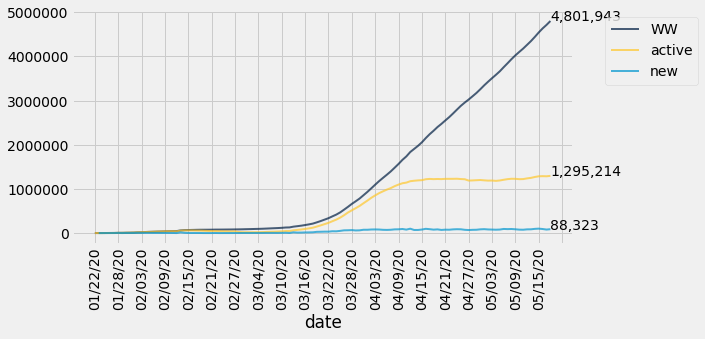

In [12]:
WW_cases = cases.select(cases.time_column)
WW_cases['WW'] = cases.sum_cols()

WW_deaths = deaths.select(cases.time_column)
WW_deaths['WW'] = deaths.sum_cols()

WW_case_trend = WW_cases.trend()

WW_case_trend.extract(['WW', 'active', 'new']).oplot(width=8, xlab=25)
label_val(WW_case_trend, last_day, 'WW')
label_val(WW_case_trend, last_day, 'active')
label_val(WW_case_trend, last_day, 'new')

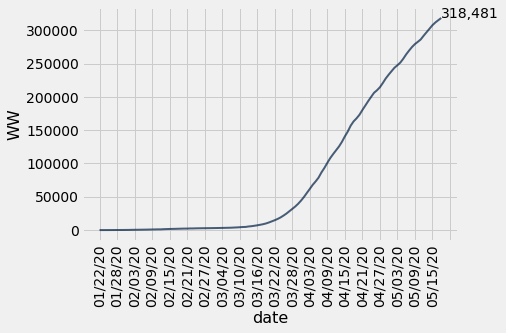

In [13]:
WW_deaths.oplot(xlab=25)
label_val(WW_deaths, last_day, 'WW')

In [14]:
# Percent of confirmed cases that have resulted in death
100*WW_deaths.last('WW')/WW_cases.last('WW')

6.632336118941853

## Pandemic Stage

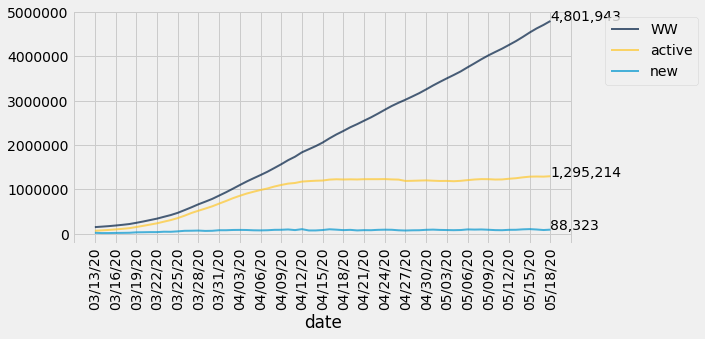

In [15]:
WW_recent = WW_case_trend.extract(['WW', 'active', 'new']).after("03/13/20")
WW_recent.oplot(width=8, xlab=25)
label_val(WW_recent, last_day, 'WW')
label_val(WW_recent, last_day, 'active')
label_val(WW_recent, last_day, 'new')

## <a id="subsectionGrowthRates"> Growth Rates </a>

A much deeper picture is revealed by looking at the day-over-day growth rates across the overall course of the infection. The following graph provides a scatter of new cases divided by that of the previous day.  The early portion is almost entirely China.  We see growth rates in the range of 50% per day until lockdown measures were put in place.

The daily growth rate had shot up to as muchj as 50% new cases per day for two weeks before the states finally took action.

https://www.businessinsider.com/coronavirus-pandemic-timeline-history-major-events-2020-3

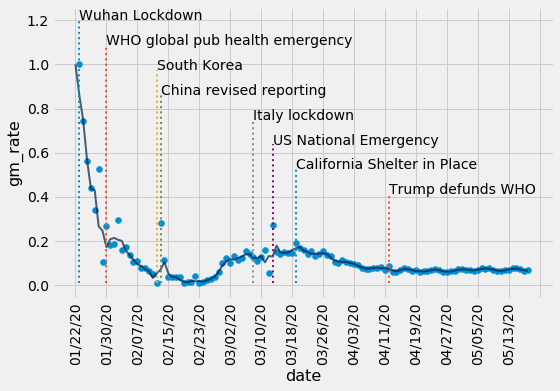

In [16]:
plot_rate_trend(WW_case_trend, 'arate')
add_lines(WW_case_trend, 'arate', 1.2, 0.3, [
    ("01/23/20", "Wuhan Lockdown"),
    ("01/30/20", "WHO global pub health emergency"),
    ("02/12/20", "South Korea"),
    ("02/13/20", "China revised reporting"),
    ("03/08/20", "Italy lockdown"),
    ("03/13/20", "US National Emergency"),
    ("03/19/20", "California Shelter in Place"),
    ("04/12/20", "Trump defunds WHO")
    ])


## Early Warning

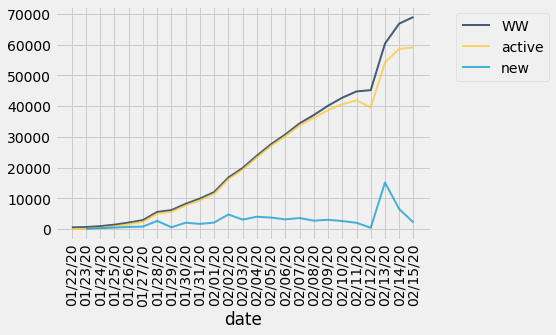

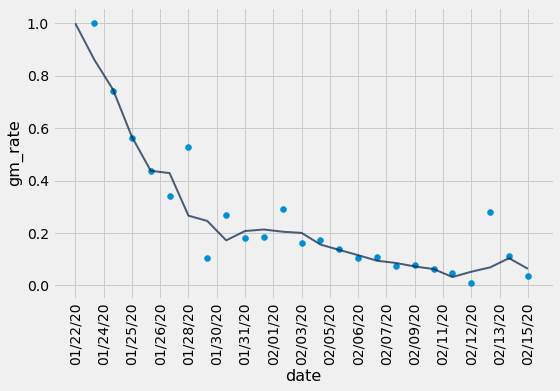

In [17]:
# Three weeks of early warning
ew_trend = WW_case_trend.before("02/15/20")
ew = ew_trend.extract(['WW', 'active', 'new'])
ew.oplot()
plot_rate_trend(ew_trend, 'arate')

## The Lost Month

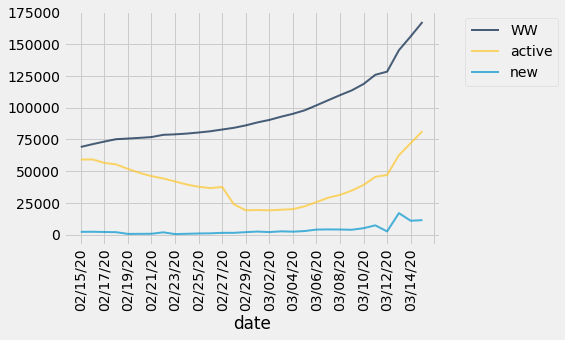

In [18]:
gap_trend = WW_case_trend.after("02/15/20").before("03/15/20")
gap = gap_trend.extract(['WW', 'active', 'new'])
gap.oplot(xlab=20)

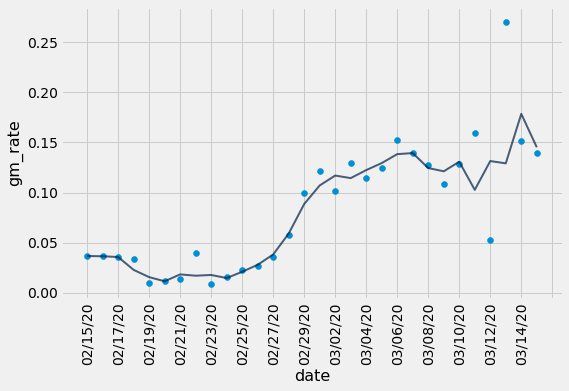

In [19]:
plot_rate_trend(gap_trend, 'arate')

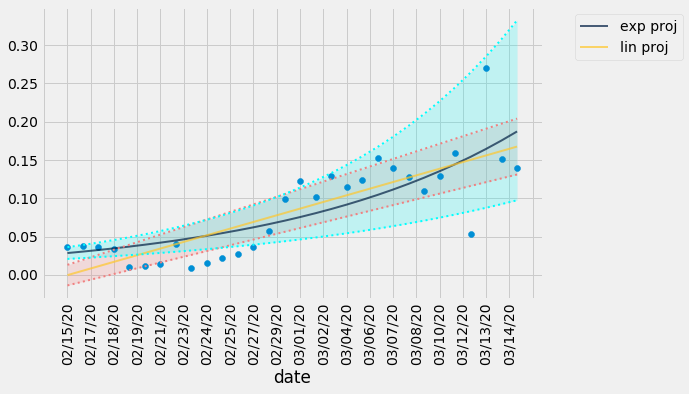

In [20]:
show_model_rate_trend(gap_trend, 'arate')

By mid-march, it was clear to the world that we were on a course to almost unimaginable crisis.

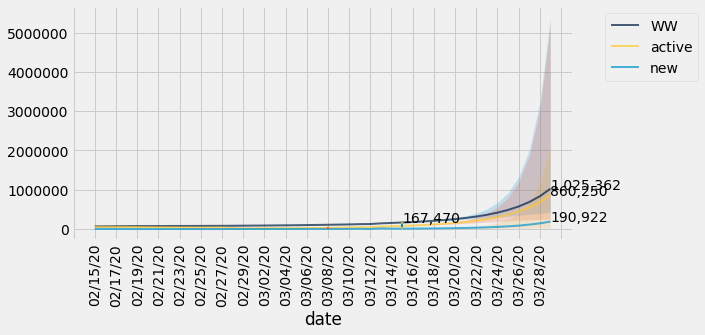

In [21]:
proj_trend(gap_trend, 'WW', start=7, end=0, dist=14)

## Mitigation

Looking at the period since mitigation measures, we find a steadily enough trend that we can hope to model the future enough to attempt predictions.

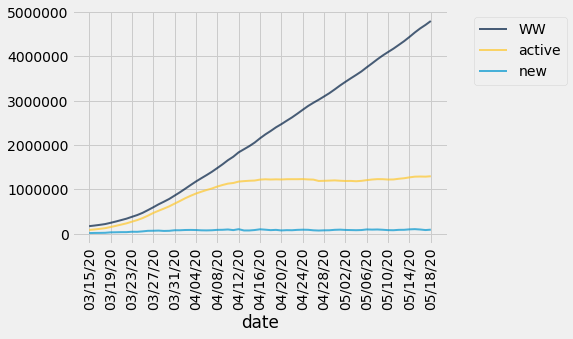

In [22]:
# Past month
mgmt_trend = WW_case_trend.after("03/15/20")
mgmt_trend.extract(['WW', 'active', 'new']).oplot(xlab=20)

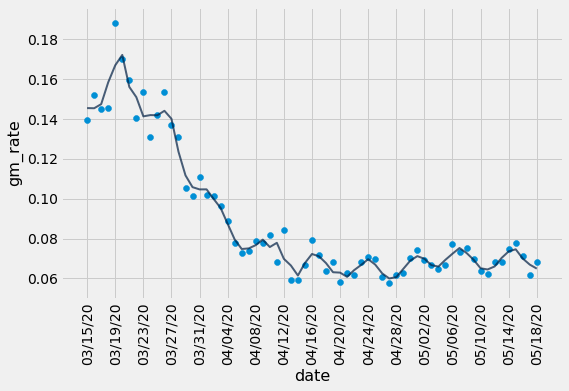

In [23]:
plot_rate_trend(mgmt_trend, 'arate')

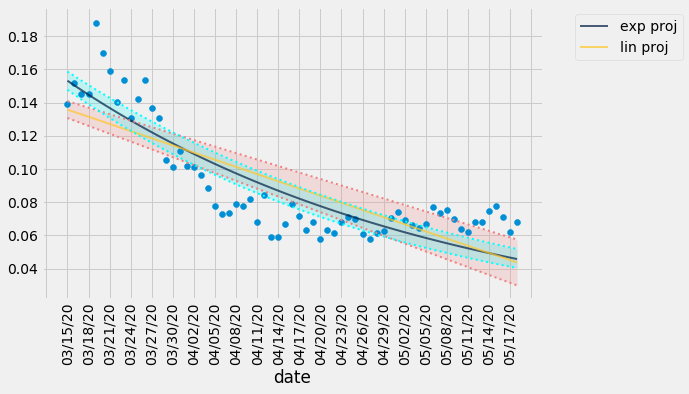

In [24]:
show_model_rate_trend(mgmt_trend, 'arate')

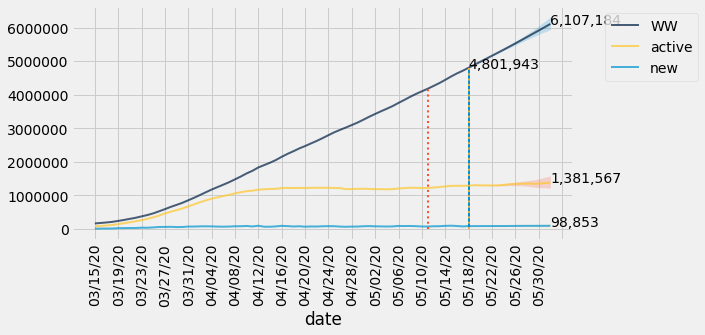

In [25]:
proj_trend(mgmt_trend, 'WW', start=7, end=0, dist=14)

In [26]:
def proj_WW(start=7, end=0, dist=14):
    proj_trend(mgmt_trend, 'WW', start=start, end=end, dist=dist)

In [27]:
_ = interact(proj_WW, start=(5,21,1), end=(0,14,1), dist=(1,45,1))

interactive(children=(IntSlider(value=7, description='start', max=21, min=5), IntSlider(value=0, description='…

Taking just the past few weeks, we can hope to get a good fit.  

What we are observing here is not the properties of viral infections processes, such as SIR models as more and more of the population gains immunities, it is fundamentally the reduction in transmission rates due to human behavior.  We are still at such minute level of immunity in the population that the classic epidemiological factors hardly matter.  The challenge is what properties should we imbue to such human behavior?  Can we expect linear improvements or is the improvement a continued reduction in the oustanding rate, i.e., exponential.  Over the short term, these cannot be meaningfully differentiated.  Clearly the linear model goes negative whereas the exponential model gradually converges to zero.  The trends are so slow that we need to go out a month or two (an eternity) to see a notable difference. The exponential model is used in the projections here.

In [28]:
WW_rate_proj, eparams, lparams, ecov, pcov = model_rate_trend(WW_case_trend.tail(14))

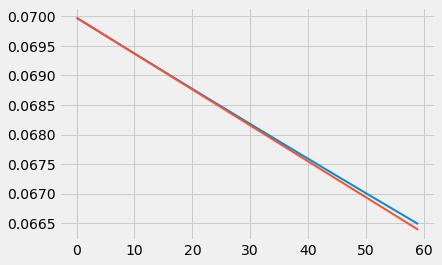

In [29]:
def ahead(n):
    plots.plot(exp_rate(range(n), eparams[0], eparams[1]))
    plots.plot(lin_rate(range(n), lparams[0], lparams[1]))

ahead(60)

## Deaths

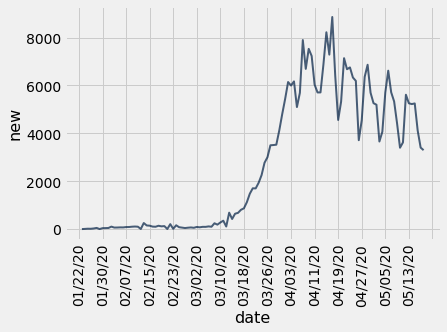

In [30]:
WW_death_trend = WW_deaths.trend(active=False)
WW_death_trend.extract('new').oplot(xlab=20)

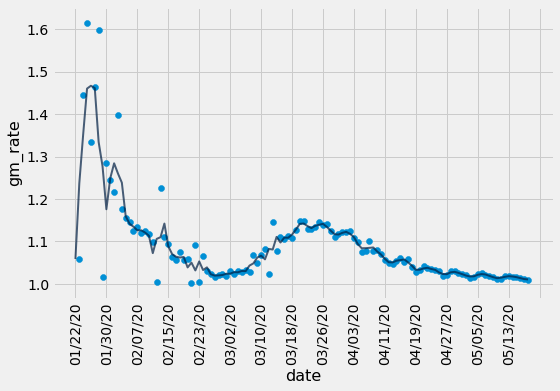

In [31]:

plot_rate_trend(WW_death_trend, 'rate')

## <a id=sectionCases>Cases to date by Country</a>

The following show the worldwide picture built up country by country.  Only the largest are shown, with the remainder
grouped into 'other'.

It begins with the current picture then shows what this would have looked like over important times past.

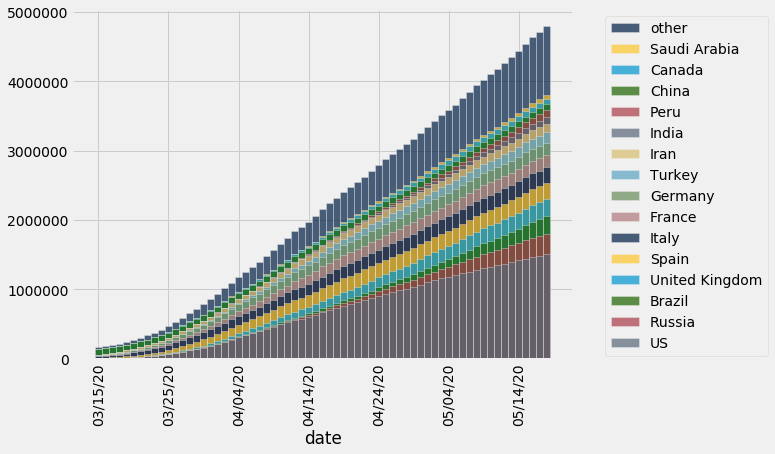

In [32]:
# Total worldwide cases broken down by Country since mitigation
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

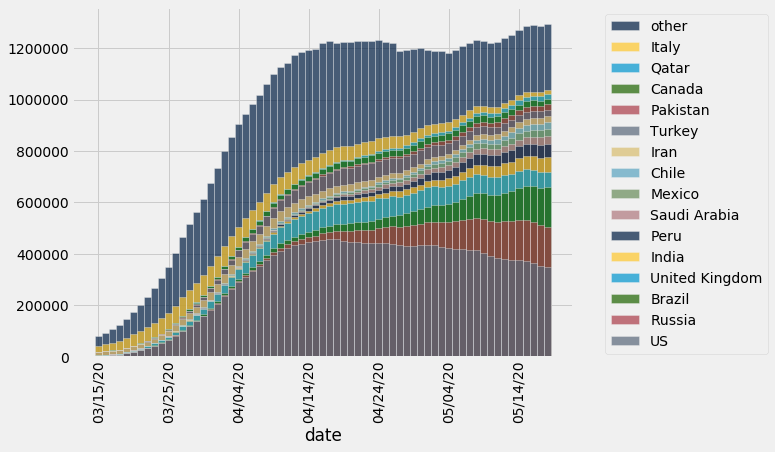

In [33]:
active.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

### The Early Warning

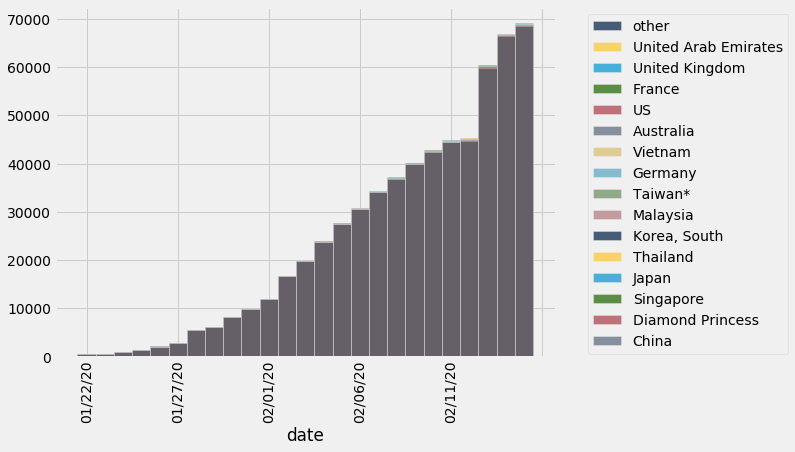

In [34]:
# And during the early warning period
cases.before("02/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

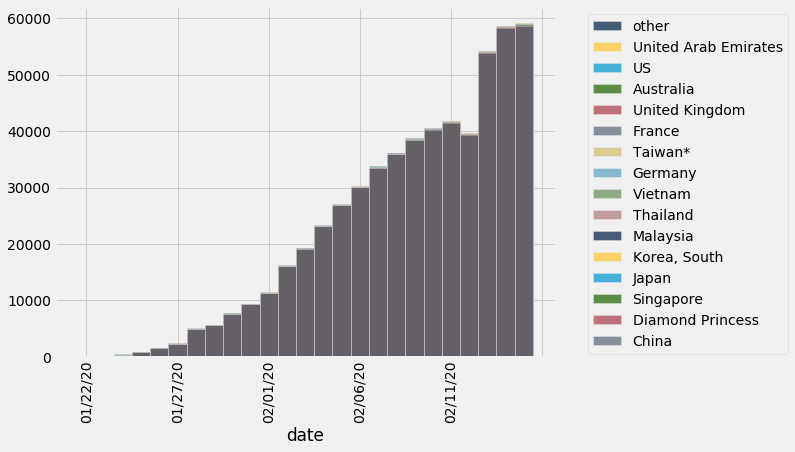

In [35]:
active.before("02/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

### The Lost Month

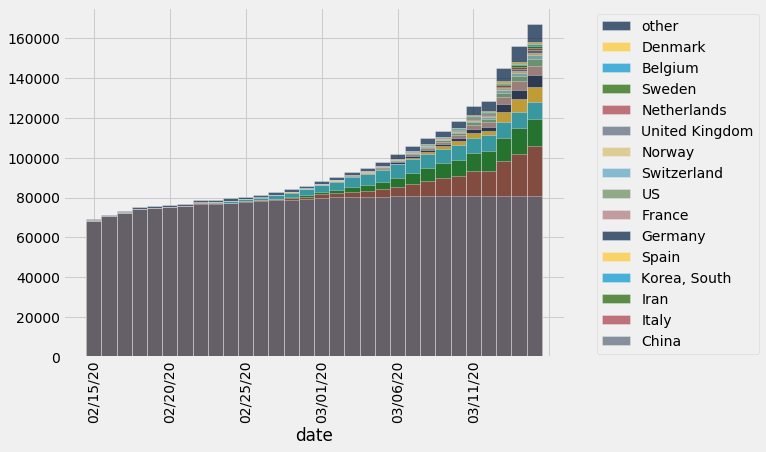

In [36]:
# What the world picture looked like during the lost month
cases.after("02/15/20").before("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

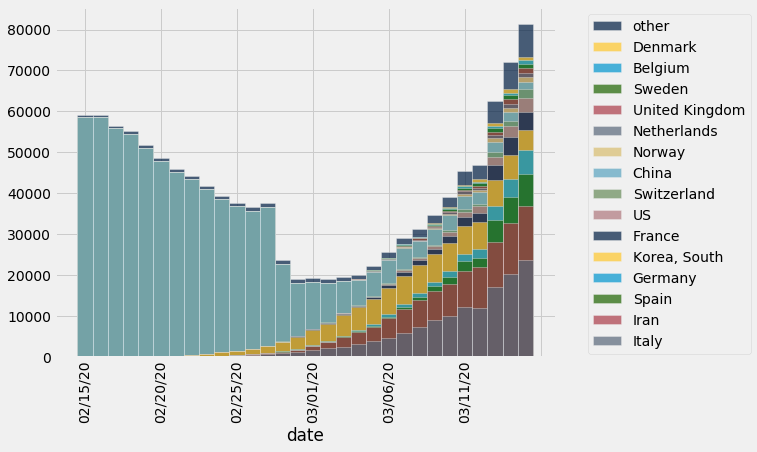

In [37]:
active.after("02/15/20").before("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

## Cases since onset of community spread

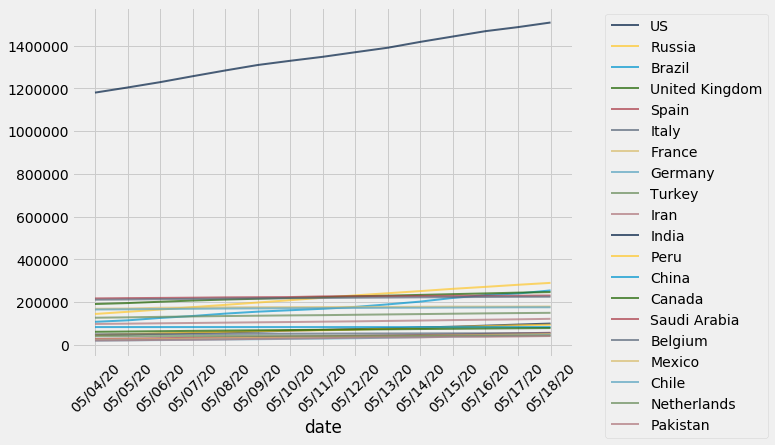

In [38]:
# Cases by country over the past two weeks
cases.top(20).tail(14).plot('date', width=8, height=6)
_ = plots.xticks(rotation=45)

In [39]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, limit=None, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            if limit :
                vals = vals[:limit]
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

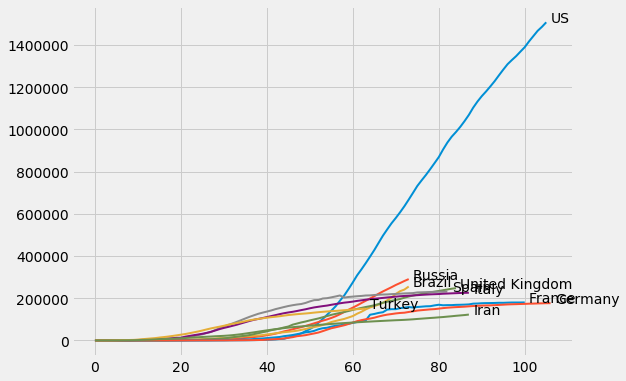

In [40]:
show_cases_since(cases.top(10), 10)

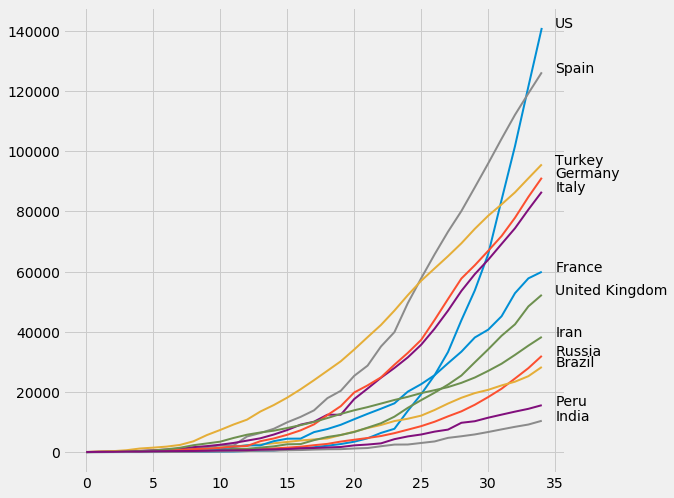

In [41]:
# First 30 days after community spread
show_cases_since(cases.top(12), 50, 35, height=8)

## <a id=sectionDeaths>Deaths to date by Country </a>

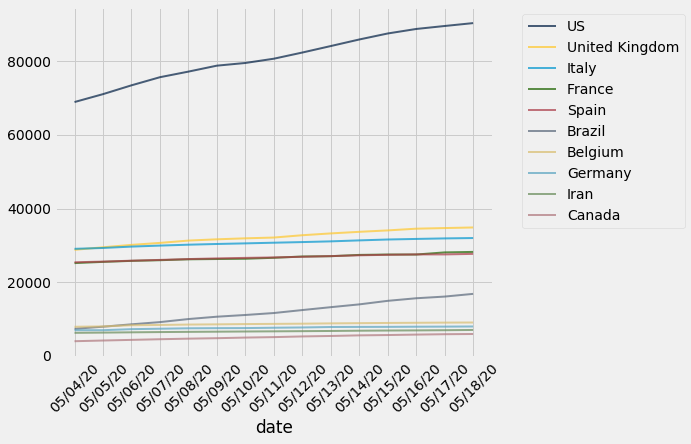

In [42]:
deaths.top(10).tail(14).plot('date', height=6, width=7)
_ = plots.xticks(rotation=45)

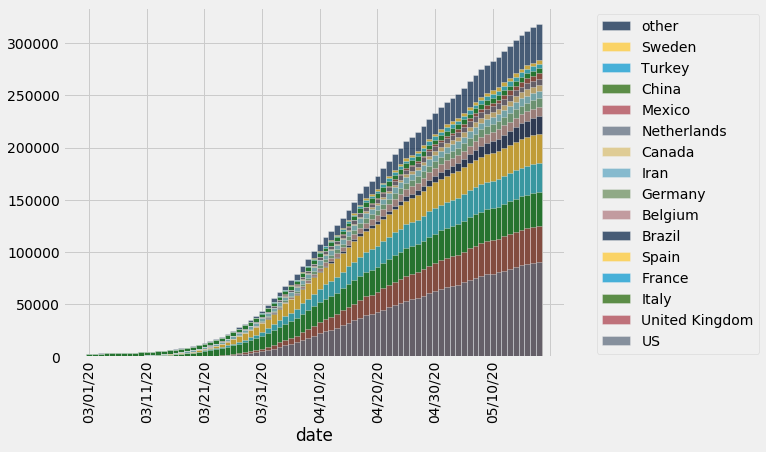

In [43]:
deaths.after("03/01/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

In [44]:
deaths.order_cols().trend(active=False).tail(7)

date,US,new US,%new US,rate US,United Kingdom,new United Kingdom,%new United Kingdom,rate United Kingdom,Italy,new Italy,%new Italy,rate Italy,France,new France,%new France,rate France,Spain,new Spain,%new Spain,rate Spain,Brazil,new Brazil,%new Brazil,rate Brazil,Belgium,new Belgium,%new Belgium,rate Belgium,Germany,new Germany,%new Germany,rate Germany,Iran,new Iran,%new Iran,rate Iran,Canada,new Canada,%new Canada,rate Canada,Netherlands,new Netherlands,%new Netherlands,rate Netherlands,Mexico,new Mexico,%new Mexico,rate Mexico,China,new China,%new China,rate China,Turkey,new Turkey,%new Turkey,rate Turkey,Sweden,new Sweden,%new Sweden,rate Sweden,India,new India,%new India,rate India,Ecuador,new Ecuador,%new Ecuador,rate Ecuador,Peru,new Peru,%new Peru,rate Peru,Russia,new Russia,%new Russia,rate Russia,Switzerland,new Switzerland,%new Switzerland,rate Switzerland,Ireland,new Ireland,%new Ireland,rate Ireland,Portugal,new Portugal,%new Portugal,rate Portugal,Indonesia,new Indonesia,%new Indonesia,rate Indonesia,Romania,new Romania,%new Romania,rate Romania,Poland,new Poland,%new Poland,rate Poland,Pakistan,new Pakistan,%new Pakistan,rate Pakistan,Philippines,new Philippines,%new Philippines,rate Philippines,Japan,new Japan,%new Japan,rate Japan,Egypt,new Egypt,%new Egypt,rate Egypt,Austria,new Austria,%new Austria,rate Austria,Colombia,new Colombia,%new Colombia,rate Colombia,Algeria,new Algeria,%new Algeria,rate Algeria,Denmark,new Denmark,%new Denmark,rate Denmark,Ukraine,new Ukraine,%new Ukraine,rate Ukraine,Chile,new Chile,%new Chile,rate Chile,Hungary,new Hungary,%new Hungary,rate Hungary,Dominican Republic,new Dominican Republic,%new Dominican Republic,rate Dominican Republic,Argentina,new Argentina,%new Argentina,rate Argentina,Bangladesh,new Bangladesh,%new Bangladesh,rate Bangladesh,Saudi Arabia,new Saudi Arabia,%new Saudi Arabia,rate Saudi Arabia,Finland,new Finland,%new Finland,rate Finland,Czechia,new Czechia,%new Czechia,rate Czechia,South Africa,new South Africa,%new South Africa,rate South Africa,Panama,new Panama,%new Panama,rate Panama,Israel,new Israel,%new Israel,rate Israel,"Korea, South","new Korea, South","%new Korea, South","rate Korea, South",Norway,new Norway,%new Norway,rate Norway,Serbia,new Serbia,%new Serbia,rate Serbia,United Arab Emirates,new United Arab Emirates,%new United Arab Emirates,rate United Arab Emirates,Moldova,new Moldova,%new Moldova,rate Moldova,Morocco,new Morocco,%new Morocco,rate Morocco,Nigeria,new Nigeria,%new Nigeria,rate Nigeria,Bolivia,new Bolivia,%new Bolivia,rate Bolivia,Afghanistan,new Afghanistan,%new Afghanistan,rate Afghanistan,Belarus,new Belarus,%new Belarus,rate Belarus,Greece,new Greece,%new Greece,rate Greece,Honduras,new Honduras,%new Honduras,rate Honduras,Cameroon,new Cameroon,%new Cameroon,rate Cameroon,Bosnia and Herzegovina,new Bosnia and Herzegovina,%new Bosnia and Herzegovina,rate Bosnia and Herzegovina,Iraq,new Iraq,%new Iraq,rate Iraq,Kuwait,new Kuwait,%new Kuwait,rate Kuwait,Malaysia,new Malaysia,%new Malaysia,rate Malaysia,Bulgaria,new Bulgaria,%new Bulgaria,rate Bulgaria,Luxembourg,new Luxembourg,%new Luxembourg,rate Luxembourg,Sudan,new Sudan,%new Sudan,rate Sudan,North Macedonia,new North Macedonia,%new North Macedonia,rate North Macedonia,Slovenia,new Slovenia,%new Slovenia,rate Slovenia,Australia,new Australia,%new Australia,rate Australia,Croatia,new Croatia,%new Croatia,rate Croatia,Cuba,new Cuba,%new Cuba,rate Cuba,Estonia,new Estonia,%new Estonia,rate Estonia,Armenia,new Armenia,%new Armenia,rate Armenia,Congo (Kinshasa),new Congo (Kinshasa),%new Congo (Kinshasa),rate Congo (Kinshasa),Lithuania,new Lithuania,%new Lithuania,rate Lithuania,Somalia,new Somalia,%new Somalia,rate Somalia,Thailand,new Thailand,%new Thailand,rate Thailand,Niger,new Niger,%new Niger,rate Niger,Chad,new Chad,%new Chad,rate Chad,Mali,new Mali,%new Mali,rate Mali,Andorra,new Andorra,%new Andorra,rate Andorra,Burkina Faso,new Burkina Faso,%new Burkina Faso,rate Burkin

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [45]:
cases.trend()

date     | Afghanistan | new Afghanistan | %new Afghanistan | rate Afghanistan | active Afghanistan | arate Afghanistan | Albania | new Albania | %new Albania | rate Albania | active Albania | arate Albania | Algeria | new Algeria | %new Algeria | rate Algeria | active Algeria | arate Algeria | Andorra | new Andorra | %new Andorra | rate Andorra | active Andorra | arate Andorra | Angola | new Angola | %new Angola | rate Angola | active Angola | arate Angola | Antigua and Barbuda | new Antigua and Barbuda | %new Antigua and Barbuda | rate Antigua and Barbuda | active Antigua and Barbuda | arate Antigua and Barbuda | Argentina | new Argentina | %new Argentina | rate Argentina | active Argentina | arate Argentina | Armenia | new Armenia | %new Armenia | rate Armenia | active Armenia | arate Armenia | Australia | new Australia | %new Australia | rate Australia | active Australia | arate Australia | Austria | new Austria | %new Austria | rate Austria | active Austria | arate Austria | Azerbaijan | new Azerbaijan | %new Azerbaijan | rate Azerbaijan | active Azerbaijan | arate Azerbaijan | Bahamas | new Bahamas | %new Bahamas | rate Bahamas | active Bahamas | arate Bahamas | Bahrain | new Bahrain | %new Bahrain | rate Bahrain | active Bahrain | arate Bahrain | Bangladesh | new Bangladesh | %new Bangladesh | rate Bangladesh | active Bangladesh | arate Bangladesh | Barbados | new Barbados | %new Barbados | rate Barbados | active Barbados | arate Barbados | Belarus | new Belarus | %new Belarus | rate Belarus | active Belarus | arate Belarus | Belgium | new Belgium | %new Belgium | rate Belgium | active Belgium | arate Belgium | Belize | new Belize | %new Belize | rate Belize | active Belize | arate Belize | Benin | new Benin | %new Benin | rate Benin | active Benin | arate Benin | Bhutan | new Bhutan | %new Bhutan | rate Bhutan | active Bhutan | arate Bhutan | Bolivia | new Bolivia | %new Bolivia | rate Bolivia | active Bolivia | arate Bolivia | Bosnia and Herzegovina | new Bosnia and Herzegovina | %new Bosnia and Herzegovina | rate Bosnia and Herzegovina | active Bosnia and Herzegovina | arate Bosnia and Herzegovina | Botswana | new Botswana | %new Botswana | rate Botswana | active Botswana | arate Botswana | Brazil | new Brazil | %new Brazil | rate Brazil | active Brazil | arate Brazil | Brunei | new Brunei | %new Brunei | rate Brunei | active Brunei | arate Brunei | Bulgaria | new Bulgaria | %new Bulgaria | rate Bulgaria | active Bulgaria | arate Bulgaria | Burkina Faso | new Burkina Faso | %new Burkina Faso | rate Burkina Faso | active Burkina Faso | arate Burkina Faso | Burma | new Burma | %new Burma | rate Burma | active Burma | arate Burma | Burundi | new Burundi | %new Burundi | rate Burundi | active Burundi | arate Burundi | Cabo Verde | new Cabo Verde | %new Cabo Verde | rate Cabo Verde | active Cabo Verde | arate Cabo Verde | Cambodia | new Cambodia | %new Cambodia | rate Cambodia | active Cambodia | arate Cambodia | Cameroon | new Cameroon | %new Cameroon | rate Cameroon | active Cameroon | arate Cameroon | Canada | new Canada | %new Canada | rate Canada | active Canada | arate Canada | Central African Republic | new Central African Republic | %new Central African Republic | rate Central African Republic | active Central African Republic | arate Central African Republic | Chad | new Chad | %new Chad | rate Chad | active Chad | arate Chad | Chile | new Chile | %new Chile | rate Chile | active Chile | arate Chile | China | new China | %new China | rate China | active China | arate China | Colombia | new Colombia | %new Colombia | rate Colombia | active Colombia | arate Colombia | Comoros | new Comoros | %new Comoros | rate Comoros | active Comoros | arate Comoros | Congo (Brazzaville) | new Congo (Brazzaville) | %new Congo (Brazzaville) | rate Congo (Brazzaville) | active Congo (Brazzaville) | arate Congo (Brazzaville) | Congo (Kinshasa) | new Congo (Kinshasa) | %new Congo (Kinshasa) | rate Congo (Kinshasa) | active Congo (Kin

In [46]:
get_rates(cases).tail(7)

date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Diamond Princess,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Grenada,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Lesotho,Liberia,Libya,Liechtenstein,Lithuania,Luxembourg,MS Zaandam,Madagascar,Malawi,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Namibia,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russia,Rwanda,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Sao Tome and Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
05/11/20,0.0903042,0.0273973,0.0669589,0,0,0,0.102263,0.0479951,0.0859375,0.0167428,0.0741525,0.0769231,0.113944,0.100633,0,0.0694042,0.0503076,nan,0,1,0.146199,0.0384,0.5,0.0647454,0,0.0362319,0.0703125,0,0,0.0909091,nan,0.102996,0.0504929,0,0,0.0715396,0.010101,0.0882259,0,0.443609,0.056701,0.0849057,0.0517241,0.0542169,0.0410628,0.0357143,0.0686528,0.0433437,nan,0.0833333,nan,0.063792,-0.00736377,0.0663853,0.104545,0,nan,0.0204082,0.0258621,0.0866142,nan,0.015625,0.0295557,0.22524,0.166667,0.0197368,0.0470755,0.13873,0.0478469,0,0.100977,0,0.049435,0.142857,0.2,0,0.0868975,0.0267857,0,0.0841224,0.0432844,0.0894975,0.0511022,0.0358895,0.0272813,0.0336059,0.0193548,0.0290939,0.191304,0.046988,0.0811594,0.136364,0.115702,0.0962808,0.0419162,nan,0.0522388,0.0921053,nan,0.137931,0,nan,0.12766,0.0121212,nan,-0.112903,0.0434783,0.0739958,0.090776,0.0247678,0.127273,0,nan,0.0602771,0.0428481,0,0,0,0.0983755,0.444444,nan,0.292683,0.032545,0,0,0.0808824,0.0718527,0.0791367,0.0446281,0.110476,0.0931584,0.0592175,nan,0.0221774,0.0366784,0.083262,0.0700786,0.0256881,0.0827085,0.0496485,0.0830229,0.0106383,nan,0,0,0,0,0.0836881,0.145679,0.0674789,nan,0.126531,0.0476564,0,0.046875,0.0535988,0.104324,0.24,0.155843,0.017341,0.124903,nan,0.0433375,0.0303975,0,0,0.0741301,0,0.0645161,nan,0.0843373,0,0,0.0375831,0.0487338,0,0.0591665,0.079728,0.0552386,0.0380952,0.110211,0.0824742,0,0,nan,0.0909091,0,0
05/12/20,0.0846626,0.0285714,0.0690196,0.2,0,0,0.111328,0.0843931,0.03861,0.114993,0.102463,0,0.105057,0.0901647,0.2,0.0711867,0.0465313,nan,0.0304183,0.5,0.0682051,0.0286678,0,0.0778203,0,0.05,0.0458015,0,0,0.0443038,nan,0,0.0506512,0,0.11254,0.0925843,0.07,0.0987266,0,0,0.121306,0.0280374,0.183261,0.0654762,0.0506024,0.0246914,0.0579897,0.0412044,nan,0.131222,nan,0.0577382,0.126759,0.0653361,0.0592593,0,nan,0.0505051,0.0756303,0.080292,nan,0.014526,0.0647505,0.0935583,0,0.0275862,0.0412822,0.119374,0.0857143,0,0.127055,0.133921,0.0789826,0.102564,0,0,-0.0140944,0.039726,0,0.0785888,0.0856183,0.0767556,0.0891182,0.0297718,0.023614,0.064306,0.013986,0.0666667,0.110236,0.0294599,0.0426136,0.12381,0.251799,0.141794,0.0614035,nan,0.030303,0.06875,nan,0,0,nan,0.142857,0.0363636,nan,0,0,0.017353

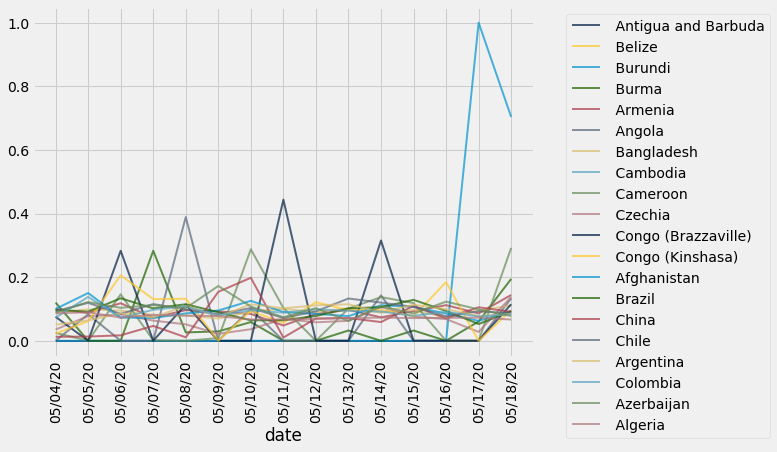

In [47]:
get_rates(cases).tail(14).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

In [48]:
def get_new(trend, region):
    return trend.last('new ' + region)

def get_rate(trend, region):
    return trend.last('rate ' + region)

def get_active(trend, region):
    return trend.last('active ' + region)

def get_arate(trend, region):
    return trend.last('arate ' + region)

def get_val(trend, region):
    return trend.last(region)

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'confirmed', [get_val(trend, r) for r in regions],
        'new',       [get_new(trend, r) for r in regions],
        'rate',      [get_rate(trend, r) for r in regions],
        'active',    [get_active(trend, r) for r in regions],
        'arate',     [get_arate(trend, r) for r in regions]

    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff arate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err'])).join(name, 
                                                     countries.select(['Country/Region', 'Lat']),'Country/Region')

In [49]:
case_sum = summary(cases, 'Country', regions)
case_sum.sort('delta', descending=True)

Country,confirmed,new,rate,active,arate,eff arate,delta,err,Lat
Burundi,42,19,1.82609,27,0.703704,-0.200617,0.118166,0.0465441,-3.3731
Zimbabwe,46,2,1.04545,12,0.166667,0.213889,0.0484127,0.142034,-20
Monaco,97,1,1.01042,2,0.5,-0.0833333,0.0416667,0.0240563,43.7333
Venezuela,618,77,1.14233,261,0.295019,0.0186655,0.0351309,0.0148804,6.4238
Syria,58,0,1,14,0,0.0321429,0.0311224,0.0276134,34.8021
West Bank and Gaza,388,7,1.01837,35,0.2,-0.0482143,0.0288487,0.00810593,31.9522
Djibouti,1518,117,1.08351,406,0.288177,0.047907,0.0252809,0.00927793,11.8251
Madagascar,322,18,1.05921,173,0.104046,0.0381142,0.0238294,0.0216465,-18.7669
Kazakhstan,6751,594,1.09648,2831,0.20982,0.0125893,0.0201116,0.00561757,48.0196
Tunisia,1043,6,1.00579,30,0.2,-0.0272358,0.0193692,0.00869867,34


In [50]:
name = 'Country'

In [51]:
def spread(summary, param):
    summary.select(name, param).sort(param).scatter(name, width=14)
    _ = plots.xticks(rotation=90, fontsize=8)

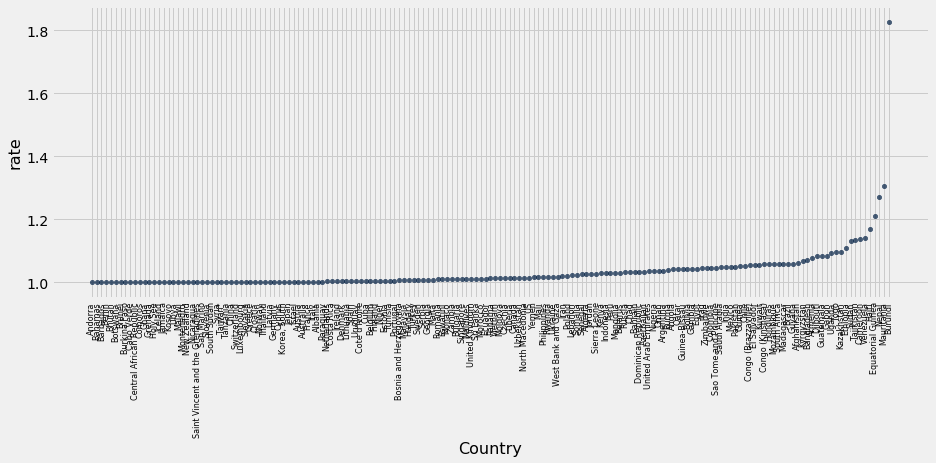

In [52]:
spread(case_sum, 'rate')

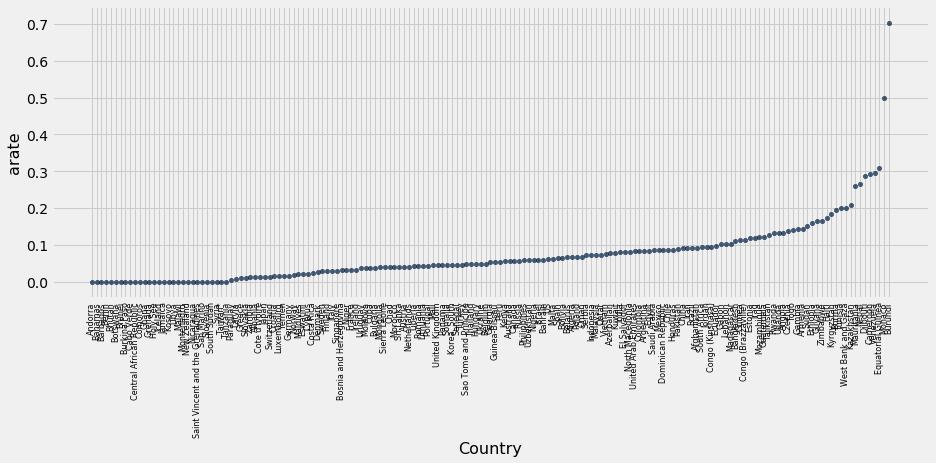

In [53]:
spread(case_sum, 'arate')

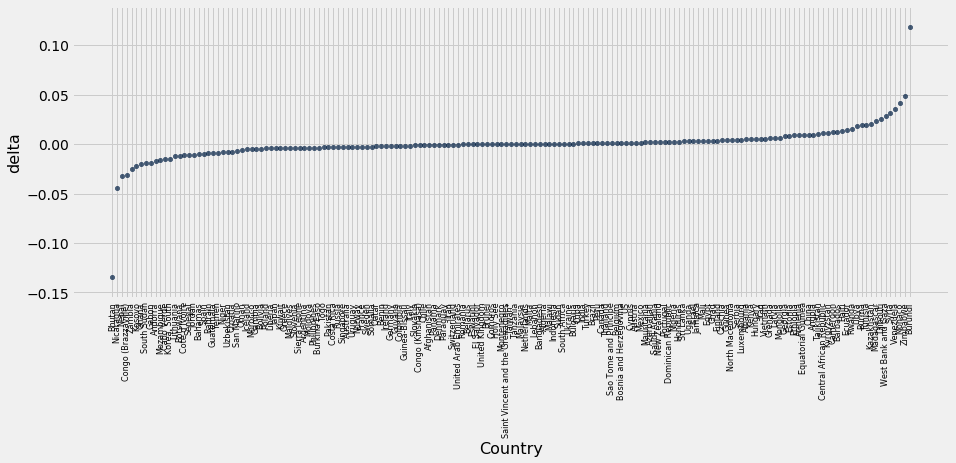

In [54]:
spread(case_sum, 'delta')

In [55]:
def label_point(summary, country, x, y):
    t = summary.where(name, country)
    if np.isfinite(t[x][0]) and np.isfinite(t[y][0]) :
        plots.text(t[x][0], t[y][0], country)

Country,confirmed,new,rate,active,arate,eff arate,delta,err,Lat
Austria,16269,27,1.00166,672,0.0401786,0.0696448,0.00138837,0.0065812,47.5162
Bangladesh,23870,1602,1.07194,14415,0.111134,0.0939968,0.000181036,0.00189038,23.685
Belarus,30572,922,1.0311,13867,0.0664888,0.0706409,-0.000333781,0.000179728,53.7098
Belgium,55559,279,1.00505,5653,0.0493543,0.044438,0.00126297,0.00134165,50.8333
Brazil,255368,14288,1.05927,153542,0.093056,0.0868318,0.00083057,0.00401335,-14.235
Canada,79411,1079,1.01377,18907,0.0570688,0.0504161,0.00111506,0.00031225,47.9829
Chile,46059,2278,1.05203,26396,0.086301,0.100641,-0.000905212,0.00348485,-35.6751
China,84063,9,1.00011,99,0.0909091,0.040426,0.00940933,0.00354544,32.8284
Colombia,16295,721,1.0463,8627,0.0835748,0.0947804,-0.00197322,0.00100168,4.5709
Denmark,11166,41,1.00369,1445,0.0283737,0.0422224,-0.000698507,0.00126023,63.2878


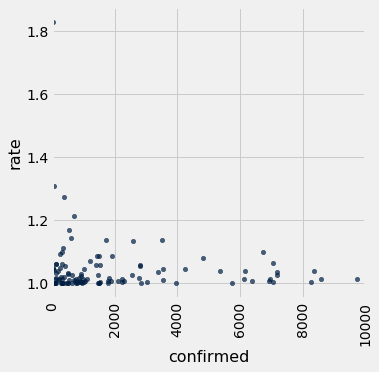

In [56]:
case_sum.scatter('confirmed', 'rate')
_ = plots.xticks(rotation=90)
plots.xlim(0,10000)
case_sum.where(case_sum['confirmed'] > 10000)

(0, 10000)

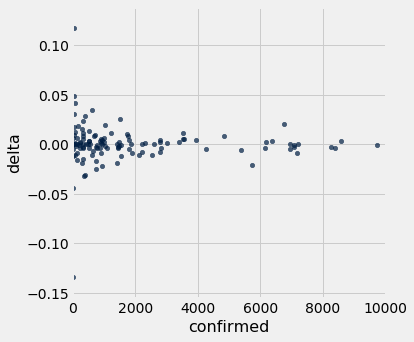

In [57]:
case_sum.scatter('confirmed', 'delta')
plots.xlim(0,10000)

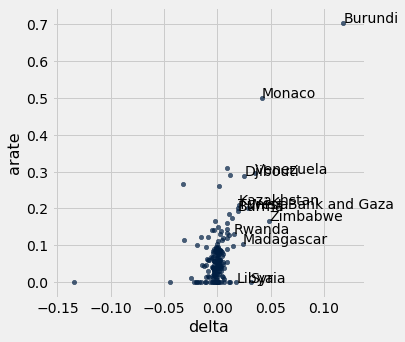

In [58]:
case_sum.scatter('delta', 'arate')
for c in case_sum.where(case_sum['delta'] > 0.015)[name] :
    label_point(case_sum, c, 'delta', 'arate')

In [59]:
case_sum.sort('rate', descending = True).take[:10]

Country,confirmed,new,rate,active,arate,eff arate,delta,err,Lat
Burundi,42,19,1.82609,27,0.703704,-0.200617,0.118166,0.0465441,-3.3731
Mauritania,81,19,1.30645,73,0.260274,0.381996,0.00181083,0.0353615,21.0079
Nepal,375,80,1.27119,300,0.266667,0.292138,-0.0323375,0.0249126,28.1667
Equatorial Guinea,719,125,1.21044,404,0.309406,0.0898948,0.00922331,0.027232,1.5
Haiti,533,77,1.16886,445,0.173034,0.118498,0.0136712,0.0112233,18.9712
Venezuela,618,77,1.14233,261,0.295019,0.0186655,0.0351309,0.0148804,6.4238
Cameroon,3529,424,1.13655,1452,0.292011,0.0523497,0.011909,0.0157324,3.848
Tajikistan,1729,205,1.13451,1601,0.128045,0.0869057,0.0104945,0.00481129,38.861
Sudan,2591,302,1.13194,1999,0.151076,0.0934917,0.000397145,0.0109647,12.8628
Ethiopia,352,35,1.11041,217,0.16129,0.0532155,0.00879338,0.00610417,9.145


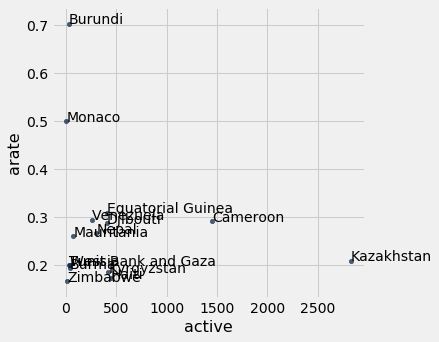

In [60]:
largest_rate = case_sum.sort('arate', descending = True).take[:15]
largest_rate.scatter('active', 'arate')
for c in largest_rate[name] :
    label_point(case_sum, c, 'active', 'arate')

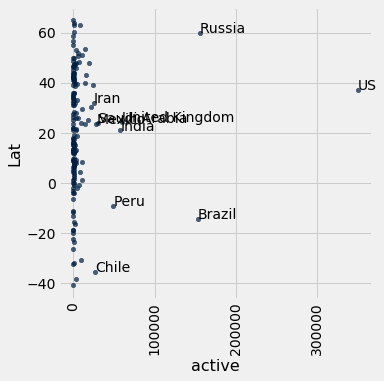

In [61]:
case_sum.scatter('active', 'Lat')
_ = plots.xticks(rotation=90)
for c in case_sum.sort('active', descending = True).take[:10][name] :
    label_point(case_sum, c, 'active', 'Lat')

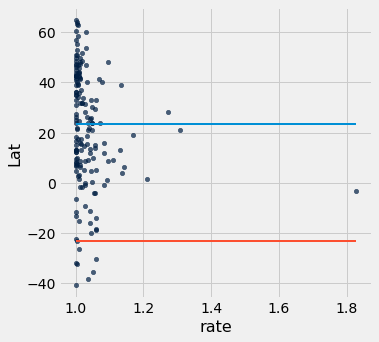

In [62]:
case_sum.scatter('rate', 'Lat')
_ = plots.plot([min(case_sum['rate']),max(case_sum['rate'])], [23.5, 23.5])
_ = plots.plot([min(case_sum['rate']),max(case_sum['rate'])], [-23.5, -23.5])

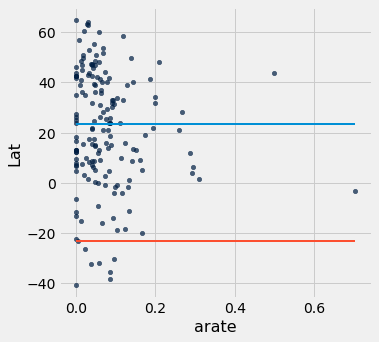

In [63]:
case_sum.scatter('arate', 'Lat')
_ = plots.plot([min(case_sum['arate']),max(case_sum['arate'])], [23.5, 23.5])
_ = plots.plot([min(case_sum['arate']),max(case_sum['arate'])], [-23.5, -23.5])

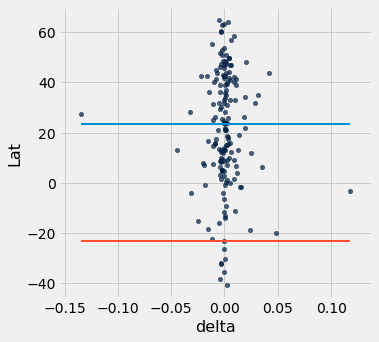

In [64]:
case_sum.scatter('delta', 'Lat')
_ = plots.plot([min(case_sum['delta']), max(case_sum['delta'])], [23.5, 23.5])
_ = plots.plot([min(case_sum['delta']), max(case_sum['delta'])], [-23.5, -23.5])

In [65]:
case_sum.sort('rate', descending=True).take[:20]

Country,confirmed,new,rate,active,arate,eff arate,delta,err,Lat
Burundi,42,19,1.82609,27,0.703704,-0.200617,0.118166,0.0465441,-3.3731
Mauritania,81,19,1.30645,73,0.260274,0.381996,0.00181083,0.0353615,21.0079
Nepal,375,80,1.27119,300,0.266667,0.292138,-0.0323375,0.0249126,28.1667
Equatorial Guinea,719,125,1.21044,404,0.309406,0.0898948,0.00922331,0.027232,1.5
Haiti,533,77,1.16886,445,0.173034,0.118498,0.0136712,0.0112233,18.9712
Venezuela,618,77,1.14233,261,0.295019,0.0186655,0.0351309,0.0148804,6.4238
Cameroon,3529,424,1.13655,1452,0.292011,0.0523497,0.011909,0.0157324,3.848
Tajikistan,1729,205,1.13451,1601,0.128045,0.0869057,0.0104945,0.00481129,38.861
Sudan,2591,302,1.13194,1999,0.151076,0.0934917,0.000397145,0.0109647,12.8628
Ethiopia,352,35,1.11041,217,0.16129,0.0532155,0.00879338,0.00610417,9.145


In [66]:
case_sum.sort('delta', descending=True).take[:20]

Country,confirmed,new,rate,active,arate,eff arate,delta,err,Lat
Burundi,42,19,1.82609,27,0.703704,-0.200617,0.118166,0.0465441,-3.3731
Zimbabwe,46,2,1.04545,12,0.166667,0.213889,0.0484127,0.142034,-20
Monaco,97,1,1.01042,2,0.5,-0.0833333,0.0416667,0.0240563,43.7333
Venezuela,618,77,1.14233,261,0.295019,0.0186655,0.0351309,0.0148804,6.4238
Syria,58,0,1,14,0,0.0321429,0.0311224,0.0276134,34.8021
West Bank and Gaza,388,7,1.01837,35,0.2,-0.0482143,0.0288487,0.00810593,31.9522
Djibouti,1518,117,1.08351,406,0.288177,0.047907,0.0252809,0.00927793,11.8251
Madagascar,322,18,1.05921,173,0.104046,0.0381142,0.0238294,0.0216465,-18.7669
Kazakhstan,6751,594,1.09648,2831,0.20982,0.0125893,0.0201116,0.00561757,48.0196
Tunisia,1043,6,1.00579,30,0.2,-0.0272358,0.0193692,0.00869867,34


<a id='sectionOneState'></a>
## Cases in one Country

These sections of the notebook allow diving into the picture for a particular state.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [67]:
w = widgets.Dropdown(options=list(countries['Country/Region']), 
                     description='Country', value='US')
display(w)

Dropdown(description='Country', index=174, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', …

In [68]:
from IPython.core.display import HTML
HTML('''<script> </script> <form action="javascript:IPython.notebook.execute_cells_below()"><input type="submit" id="toggleButton" value="Run All Below"></form>''')

In [69]:
country = w.value
country_case_trend = cases.extract(country).trend()
country

'US'

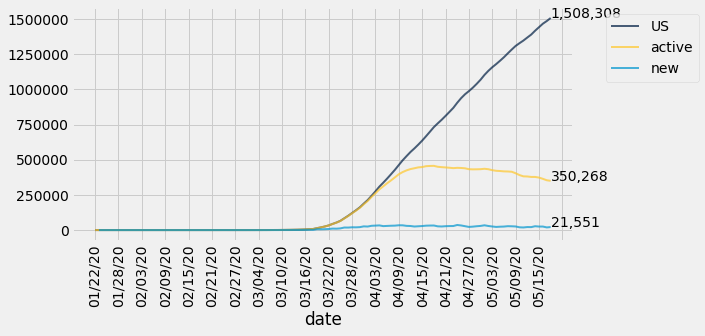

In [70]:
country_case_trend.extract([country, 'active', 'new']).oplot(width=8, xlab=25)
label_val(country_case_trend, last_day, country)
label_val(country_case_trend, last_day, 'active')
label_val(country_case_trend, last_day, 'new')

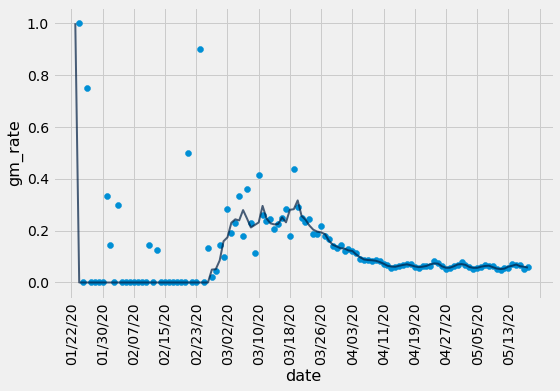

In [71]:
plot_rate_trend(country_case_trend, 'arate')

In [72]:
country_recent = country_case_trend.after("03/15/20")

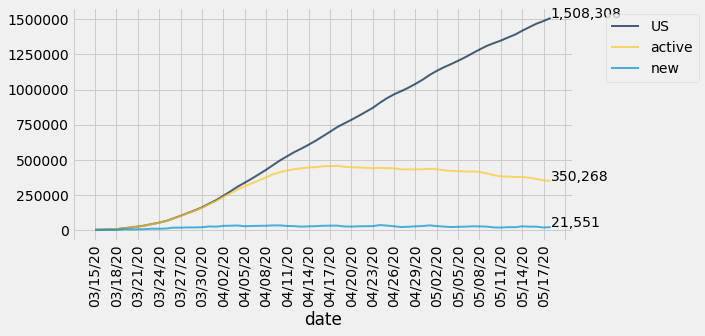

In [73]:
country_recent.extract([country, 'active', 'new']).oplot(width=8, xlab=25)
label_val(country_recent, last_day, country)
label_val(country_recent, last_day, 'active')
label_val(country_recent, last_day, 'new')

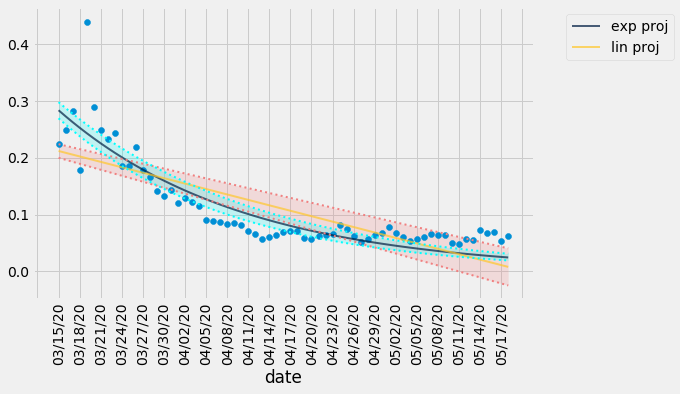

In [74]:
show_model_rate_trend(country_recent, 'arate')

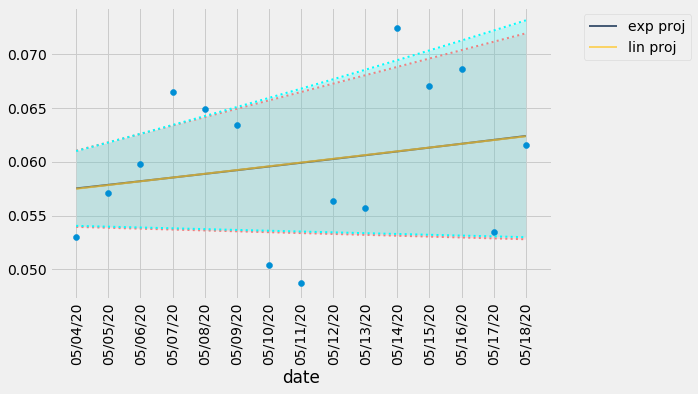

In [75]:
show_model_rate_trend(country_recent.tail(14), 'arate')

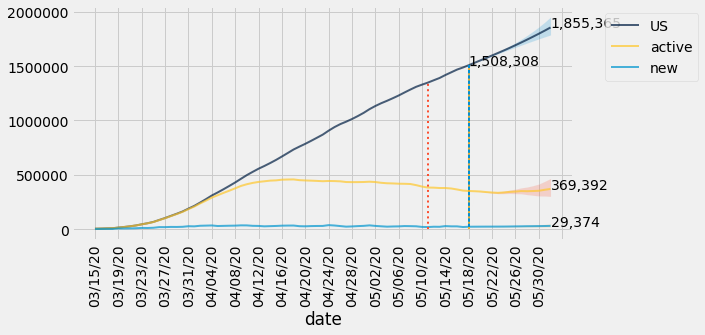

In [76]:
proj_trend(country_recent, country, start=7, end=0, dist=14)

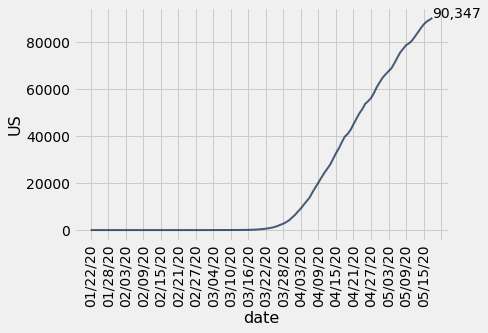

In [77]:
deaths.extract(country).oplot(xlab=25)
label_val(deaths, last_day, country)